# Guided Test Case Generation System Notebook

In [1]:
# Basic libraries
import os, sys
import numpy as np
import re
import string
from datetime import datetime
import math
import pandas as pd

import utils

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Speech
import soundfile as sf # pip install pysoundfile
import python_speech_features as speech_lib # pip install python_speech_features


# Machine learning
import nltk
import xgboost
from sklearn.utils import shuffle
from sklearn.base import clone as clone_model
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import joblib

import tensorflow as tf


%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

### Read Data

In [2]:
DEEPSPEECH = "deepspeech"
ALEXA = "alexa"
GCLOUD = "gcloud"
CHROMESPEECH = "gspeech"
WIT = "wit"
WAV2LETTER = "wav2letter"
PADDLEDEEPSPEECH = "paddledeepspeech"
SR = [DEEPSPEECH, WIT, WAV2LETTER, PADDLEDEEPSPEECH]

df = {}
for sr in SR :
    df[sr] = utils.read_data("training_data/" + sr + ".txt")

BUG_LABEL = 1
NON_BUG_LABEL = 0
UNDETERMINED_LABEL = -1

In [3]:
df[WIT].head()

,sentence,label
0,had laid before her a pair of alternatives now...,-1
1,property erects a kind of barrier you can do a...,-1
2,i mean of course if you'll take a companion so...,-1
3,she'd keep people off very well i think,1
4,that it's a great deal better you should remai...,1


### Number of Fail Test Case and Success Test Case

In [4]:
fail_test_case = utils.get_fail_test_case(df)
print(len(fail_test_case))

7475


In [5]:
success_test_case = utils.get_success_test_case(df)
print(len(success_test_case))

98


### Data distribution





deepspeech


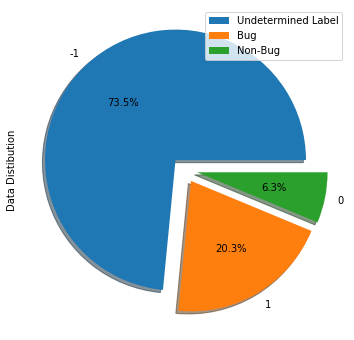





wit


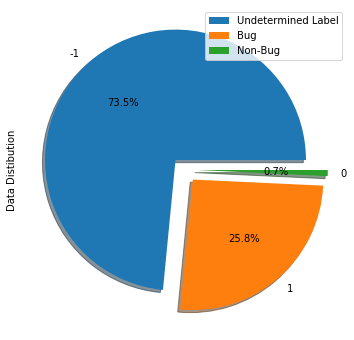





wav2letter


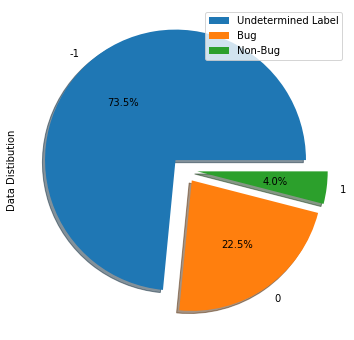





paddledeepspeech


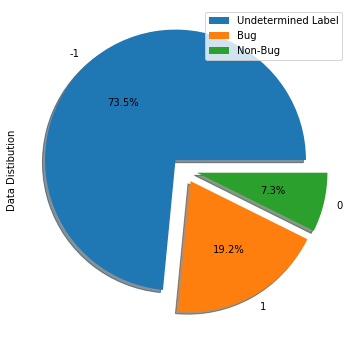

In [6]:
for key in df.keys() :
    print("\n\n\n")
    print(key)
    # print(df[key].groupby("label").describe())
    df[key]["label"].value_counts().plot(kind = 'pie', explode = [0.1, 0.1, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
    plt.ylabel("Data Distibution")
    plt.legend(["Undetermined Label", "Bug", "Non-Bug"])
    plt.show()

we need to handle imbalance data

### Handle Imbalance Data

Resample Size: 7362


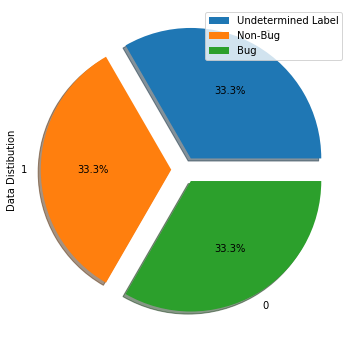

In [7]:
RESAMPLE_SIZE = utils.getResampleSize(df)
print("Resample Size: %d" % RESAMPLE_SIZE)

sample = utils.resampleToFixNumber(df["deepspeech"], RESAMPLE_SIZE)
sample["label"].value_counts().plot(kind = 'pie', explode = [0.1, 0.1, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Data Distibution")
plt.legend(["Undetermined Label", "Non-Bug", "Bug"])
plt.show()

### Feature Extraction

In [8]:
NUM_CORES = 4
EMBEDDING_SIZE = 13

In [9]:
from gensim.models import Word2Vec

corpus_sentence = pd.read_csv('corpus-sentence.txt', sep=",", header=None)
corpus_sentence.columns = ["sentence"]
tokenized_corpus = list(corpus_sentence['sentence'].apply(utils.text_process))

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    size=EMBEDDING_SIZE,
    min_count=1,
    window=5,
    workers=NUM_CORES,
    seed=1337
)

w2v_model.save("model/word2vec.model")

# Show that similar words to 'program' print
# w2v_model.wv.most_similar(positive='program')

# Encode the documents using the new embedding
encoded_docs = [[w2v_model.wv[word] for word in sentence] for sentence in tokenized_corpus]

### Length variation on each sentence

In [10]:
print(len(encoded_docs[0]))
print(len(encoded_docs[1])) 
# print(encoded_docs[0]) 

42
40


In [11]:
def max_length_sentence_from_corpus(encoded_docs):
    max = 0
    for encoded_sentence in encoded_docs :
        if (len(encoded_sentence) > max) :
            max = len(encoded_sentence)
    return max


MAX_LENGTH = max_length_sentence_from_corpus(encoded_docs)
MAX_LENGTH

75

In [12]:
# because the length of each sentence is various 
# and we use non-sequential machine learning model
# we need to make padding for each sentences
def create_padding_on_sentence(encoded_docs) :
    padded_posts = []

    for post in encoded_docs:

        # Pad short posts with alternating min/max
        if len(post) < MAX_LENGTH:

            padding_size = MAX_LENGTH - len(post)

            for _ in range(0, padding_size) :
                post.append(np.zeros((EMBEDDING_SIZE)))


        # Shorten long posts or those odd number length posts we padded to MAX_LENGTH
        if len(post) > MAX_LENGTH:
            post = post[:MAX_LENGTH]

        # Add the post to our new list of padded posts
        padded_posts.append(post)
    
    return padded_posts

In [13]:
def flatten_docs(padded_docs) :
    flatten = []
    for sentence in padded_docs:
        ps = []
        for word in sentence :
            for feature in word :
                ps.append(feature)
        flatten.append(ps)
    return np.asarray(flatten)

In [14]:
temp_data = utils.resampleToFixNumber(df["deepspeech"], RESAMPLE_SIZE)
temp_data = utils.shuffle_data(temp_data)

In [15]:
temp_data.head()

,sentence,label
0,and doctor arabin had promised that no one els...,-1
1,when she should be launched and lying alongsid...,-1
2,the creature in fine as to whom spangles or sp...,-1
3,he heard the cry privilege of parliament privi...,0
4,he saw a lady a fashionable elegantly dressed ...,0


In [16]:
def extract_feature(docs) :
    tokenized_sentences = docs.apply(utils.text_process)
    encoded_docs = [[w2v_model.wv[word] for word in sentence] for sentence in tokenized_sentences]
    padded_docs = create_padding_on_sentence(encoded_docs)
    flatten_array = flatten_docs(padded_docs)
    return flatten_array

In [17]:
temp_data["sentence"][0]

'and doctor arabin had promised that no one else should be in the house if mister crawley objected to society but this was not what he wanted the finery and grandeur of the deanery and the comfort of that warm snug library would silence him at once'

In [18]:
flatten_array = extract_feature(temp_data['sentence'])

In [19]:
# flatten_array[0]

In [26]:
# https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = RandomForestClassifier(n_estimators=31, random_state=111)

    
    score = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8,shuffle=True), n_jobs=2, verbose=2)
    return np.mean(score)

In [27]:
evaluate_features(flatten_array, temp_data["label"])

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished


0.8489541160213434

## Experiment

### Prepare Model

In [22]:
N_JOBS = 4

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=10)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='lbfgs', n_jobs=N_JOBS)
rfc = RandomForestClassifier(n_estimators=31, random_state=111, n_jobs=N_JOBS)
abc = AdaBoostClassifier(n_estimators=31, random_state=111)
bc = BaggingClassifier(n_estimators=10, random_state=111, n_jobs=N_JOBS)
etc = ExtraTreesClassifier(n_estimators=10, random_state=111, n_jobs=N_JOBS)
xgb = xgboost.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)

In [23]:
clfs = {'SVC' : svc,'KN' : knc, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc }

### Model Evaluation

In [24]:
features = {}
labels = {}
for k,v in df.items() :
    data = utils.resampleToFixNumber(v, RESAMPLE_SIZE)
    features[k] = extract_feature(data["sentence"])
    labels[k] = data["label"]

#### Performance

In [25]:
for clf_name, clf in clfs.items() :
    accuracy = []
    for k,v in df.items() :
        acc = evaluate_features(features[k], labels[k], clf)
        accuracy.append(acc)

    print('Average accuracy %s: %.2f' % (clf_name, np.mean(accuracy)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

### Trying Model in the First Batch

In [25]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
    
def predict_labels(clf, features):
    return clf.predict(features)

# intersection between 2 sets
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

In [26]:
k = list(df.keys())[0]
FIRST_BATCH_SIZE = math.ceil(len(df[k]["label"]) * 3 / 4 )
# FIRST_BATCH_SIZE = math.ceil(len(df[k]["label"]) / 2 )
BATCH_SIZE = math.ceil(len(df[k]["label"]) / 2 / 3)
MAX_SIZE = len(df[k]["label"])

features = {}
labels = {}
for k,v in df.items() :
    data = v[:FIRST_BATCH_SIZE]
    data = resampleToFixNumber(data, RESAMPLE_SIZE)
    features[k] = extract_feature(data["sentence"])
    labels[k] = data["label"]

In [30]:
models = {}
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "RF", "AdaBoost", "BgC", "ETC", "XGB"]
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "AdaBoost", "XGB"]
# selected_clfs = ["RF"]
selected_clfs = ["KN", "DT", "LR", "RF", "AdaBoost", "ETC"]
for k in selected_clfs :
    per_sr_model = {}
    for key_sr in features.keys() :
        model = None
        model = clone_model(clfs[k])
        train_classifier(model, features[key_sr], labels[key_sr])
        per_sr_model[key_sr] = model
    models[k] = per_sr_model
    
for clf in models.keys() :
    for sr in models[clf].keys():
        filename = "model/" + clf + "_" + sr + ".sav"
        joblib.dump(models[clf][sr], filename)

### Trying Model for the Next Batch until Finish

In [31]:
performance_writer = open(
        "performance/word2vec_" + str(datetime.now()) + ".txt", "w+")


for key_clf, v in models.items() :
    # classify the selected data
    training_data = {}
    for key_sr, model in v.items():
        training_data[key_sr] = df[key_sr][:FIRST_BATCH_SIZE]

    lower_bound = FIRST_BATCH_SIZE

    columns = ["Predicted", "CorrectlyPredictedBug", "UndetectedBug", "Precision", "Recall", "F1"]
    index = []
    performance_data = []

    while (lower_bound < MAX_SIZE) :
        # set the upper bound size
        upper_bound = lower_bound + BATCH_SIZE
        if (upper_bound > MAX_SIZE) :
            upper_bound = MAX_SIZE
        batch = str(lower_bound) + " - " + str(upper_bound)
        index.append(batch)
            
        union_used_index = []
        union_bug_index = []
        bug_index_per_model = {}
            
        for key_sr, model in v.items():
            # get the data to be selected
            current_data = df[key_sr][lower_bound:upper_bound]
            current_sentence = current_data["sentence"]
            current_labels = current_data["label"]

            # extract feature from the data
            current_features = extract_feature(current_sentence)

            # predict the current data
            pred = predict_labels(model, current_features)

            # see the classifier performance
            used_index = np.where(pred == BUG_LABEL)
            bug_index = np.where(current_labels == BUG_LABEL)
            
            union_used_index = list(set().union(union_used_index, used_index[0]))
            union_bug_index = list(set().union(union_bug_index, bug_index[0]))
            bug_index_per_model[key_sr] = bug_index[0]
            

        intersect = intersection(union_used_index, union_bug_index)
        intersection_length = len(intersect)
        undetected_bug = len(union_bug_index)-intersection_length
        precision = 0
        if (len(union_used_index) != 0) :
            precision = round(intersection_length/len(union_used_index), 2)
        recall = 0
        if ((intersection_length + undetected_bug) != 0) :
            recall = round(intersection_length/(intersection_length + undetected_bug), 2)
        precision_recall = precision + recall
        f1 = 0
        if precision_recall != 0 :
            f1 = round( 2 * precision * recall / (precision_recall), 2)
        performance_data.append([len(union_used_index), intersection_length, undetected_bug, precision, recall, f1])
        
        # add the predicted data to previous data
        if (len(union_used_index) > 0) :
            for key_sr, bug_index in bug_index_per_model.items() :
                intersection_index = intersection(union_used_index, bug_index)
                added_data = current_data.iloc[intersection_index,:]
                training_data[key_sr].append(added_data)
                
                # handle imbalance data
                resampled_data = resampleToFixNumber(training_data[key_sr], RESAMPLE_SIZE)

                # re-extract feature
                features[key_sr] = extract_feature(resampled_data["sentence"])
                labels[key_sr] = resampled_data["label"]

                # re-train the model 
                train_classifier(model, features[key_sr], labels[key_sr])

        # update the lower bound
        lower_bound = upper_bound

    performance = pd.DataFrame(performance_data, index=index, columns=columns)
    print("Classifier: " + key_clf) 
    print(performance)
    generated = int(performance["Predicted"].sum(axis=0))
    correctly_predicted_bug = int(performance["CorrectlyPredictedBug"].sum(axis=0))
    undetected_bug =  int(performance["UndetectedBug"].sum(axis=0))
    precision = round(performance["Precision"].mean(), 2)
    recall = round(performance["Recall"].mean(), 2)
    f1 = round(performance["F1"].mean(), 2)
    print("Total Generated: %d" % (generated))
    print("Correctly Predicted Bug: %d" % (correctly_predicted_bug))
    print("Undetected Bug: %d" % (undetected_bug))
    print("Total bug: %d" % (correctly_predicted_bug + undetected_bug) )
    print("Precision: %.2f" % (precision))
    print("Recall: %.2f" % (recall))
    print("F1: %.2f" % (f1))
    print("\n")
    
    performance_writer.write("Classifier: %s" % (key_clf))
    performance_writer.write("\n" + str(performance))
    performance_writer.write("\nTotal Generated: %d" % (generated))
    performance_writer.write("\nCorrectly Predicted Bug: %d" % (correctly_predicted_bug))
    performance_writer.write("\nUndetected Bug: %d" % (undetected_bug))
    performance_writer.write("\nTotal bug: %d" % (correctly_predicted_bug + undetected_bug) )
    performance_writer.write("\nPrecision: %.2f" % (precision))
    performance_writer.write("\nRecall: %.2f" % (recall))
    performance_writer.write("\nF1: %.2f" % (f1))
    performance_writer.write("\n\n")

performance_writer.close()

Classifier: KN
               Predicted  CorrectlyPredictedBug  UndetectedBug  Precision  \
21405 - 26162       4102                   2380            380       0.58   
26162 - 28539       2017                   1148            204       0.57   

               Recall    F1  
21405 - 26162    0.86  0.69  
26162 - 28539    0.85  0.68  
Total Generated: 6119
Correctly Predicted Bug: 3528
Undetected Bug: 584
Total bug: 4112
Precision: 0.57
Recall: 0.86
F1: 0.68


Classifier: DT
               Predicted  CorrectlyPredictedBug  UndetectedBug  Precision  \
21405 - 26162       3603                   2133            627       0.59   
26162 - 28539       1817                   1070            282       0.59   

               Recall    F1  
21405 - 26162    0.77  0.67  
26162 - 28539    0.79  0.68  
Total Generated: 5420
Correctly Predicted Bug: 3203
Undetected Bug: 909
Total bug: 4112
Precision: 0.59
Recall: 0.78
F1: 0.68


Classifier: LR
               Predicted  CorrectlyPredictedBug  Undete